In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D

## Question 2: Solve for representative agent steady state

In [68]:
def params1():
    
    θ = 0.21
    ν = 0.64
    δ = 0.1
    β = 0.96
    ϕ = 0.5
    ρ = 0.9
    σ = 0.02
    cf = 0.01
    ce = 0.1
    
    params = θ, ν, δ, β, ϕ, ρ, σ, cf, ce
    
    return params

In [69]:
def get_markov_shocks(*params):
    
    # unpack params
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    
    # markov approximation of shocks using quantecon
    shock_matrix = qe.markov.approximation.tauchen(ρ, σ, n = 10)

    return shock_matrix

def get_SS_shocks(markov_shocks):
    
    SS_shock = markov_shocks.stationary_distributions
    
    return SS_shock

def get_r(K, N, shock, *params):
    
    # unpack params
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    
    r = θ * np.exp(shock) * K**(θ-1) * N**ν
    
    return r

def get_w(K, N, shock, *params):
    
    # unpack params
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    
    w = ν * np.exp(shock) * K**θ * N**(ν-1)
    
    return w

def get_c(w, r, K, N, *params):
    
    # unpack params
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    
    c = w * N + r * K - (K - (1 - δ) * K)
    
    return c

def get_pi(w, r, K, N, shock, *params):
    
    # unpack params
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    
    pi = np.exp(shock) * K**θ * n**ν - w*N
    
    return pi

def SS_rep(K, N, shock, *params):
    
    # unpack params
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    
    w = get_w(K, N, shock, *params)
    
    f1 = -1 - ϕ*δ + β*(θ * K**(θ-1) * N**ν - (ϕ/2) * δ**2 + (ϕ - 1)*δ + 1)
    
    return f1

def model_SS(K_guess, N, shock, *params):
    
    K_ss = opt.fsolve(SS_rep, K_guess, args = (N, shock, *params))
    w_ss = get_w(K_ss, N, shock, *params)
    r_ss = get_r(K_ss, N, shock, *params)
                      
    return K_ss,w_ss,r_ss

model_SS(1, 0.6, 0, *params1())

(array([1.04511682]), array([0.77637249]), array([0.14625]))

## Question 3: Solve for incumben firms decision rule
- follow similar Euler equation for Q2, adding stochastic shocks,  entry and exit.

In [88]:
def V1_fun(k, kp, ϵ, w_rep, V_guess, Markov_chain, *params):
    
    # unpack params
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    
    # labour supply
    n = (w_rep/(ν*np.exp(ϵ)*(k**θ)))**(1/(ν-1))

    EV = np.dot(V_guess, Markov_chain)

    V1 = np.exp(ϵ)*(k**(θ))*(n**(ν)) - w_rep*n - (kp - (1-δ)*k) - k*(ϕ/2)*(kp/k - (1-δ))**2 + β * EV

    return V1

def iteration(Markov_chain, w_rep, N, tol, maxiter, *params, show = True, plot = True):
    
    # unpack params:
    θ, ν, δ, β, ϕ, ρ, σ, cf, ce = params
    transition = Markov_chain.P
    shock = Markov_chain.state_values
    
    # set capital grid:
    klow = 0.01
    khigh = 1.5
    k_grid = np.linspace(klow, khigh, N)
    
    # set value grid and the equilibrium value gird:
    v_grid = 0.01 * np.ones((N, 10))
    v_eqbm = np.zeros_like(v_grid)
    
    # set policy grid:
    policy = np.zeros_like(v_grid)
    
    # iterate over value function:
    for iters in range(maxiter):
        if show == True and iters % 50 == 0:
            print('iteration {}'.format(iters))
        for i in range(N): # first loop through all k's
            k = k_grid[i]
            for j in range(10): # then loop through all shocks
                ϵ = shock[j]
                markov = transition[j, :]
                max_value = -np.inf
                index = 0
                for m in range(N): # loop through all k's again to find best next period k
                    kp = k_grid[m]
                    V_guess = v_grid[m, :]

                    potential_max = V1_fun(k, kp, ϵ, w_rep, V_guess, markov, *params)

                    if (1-δ)*k > potential_max - cf: # exit condition
                        if max_value < (1-δ)*k:
                            max_value = (1-δ)*k
                            index = -khigh # if exit gives maximum value, give a negative policy rule

                    else:
                        if max_value < potential_max - cf:
                            max_value = potential_max - cf
                            index = m
                
                v_eqbm[i, j] = max_value # update v_eqbm

                # track policy function
                if index >= 0:
                    policy[i, j] = k_grid[index]
                else:
                    policy[i, j] = index
                    
        diff = np.max(np.abs(v_eqbm - v_grid))
        if show == True and iters % 50 == True:
            print('maximum value difference is {}'.format(diff))
        if diff < tol:
            break
        v_grid = v_eqbm.copy()
        
    if plot == True:
        sshock, ccapital = np.meshgrid(shock, k_grid)
        # value function plot:
        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(111, projection ='3d')
        ax.scatter(sshock, ccapital, v_eqbm)
        ax.set_xlabel('discrete shocks')
        ax.set_ylabel('capital')
        ax.set_zlabel('value')
        plt.show()

        # policy function plot:
        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(111, projection ='3d')
        ax.scatter(sshock, ccapital, policy)
        ax.set_xlabel('discrete shocks')
        ax.set_ylabel('capital')
        ax.set_zlabel('policy')
        plt.show()

            
    return v_eqbm, policy

In [89]:
markov_chain = get_markov_shocks(*params1())
w_rep = float(model_SS(1, 0.6, 0, *params1())[1])

iteration 0
maximum value difference is 0.28743073900766114
iteration 50
maximum value difference is 0.013823501700829688
iteration 100
maximum value difference is 0.001786550897526773
iteration 150
maximum value difference is 0.00023204209816629628
iteration 200
maximum value difference is 3.0138968681647782e-05
iteration 250
maximum value difference is 3.914623862399935e-06


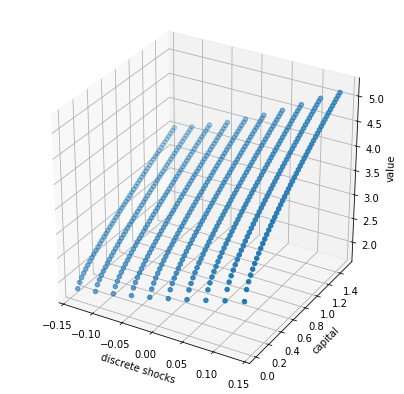

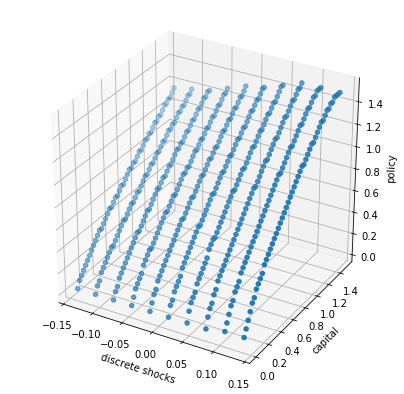

In [93]:
value, policy = iteration(markov_chain, w_rep, 50, 1e-6, 1000, *params1(), show = True, plot = True)

## Exercise 4